In [1]:
import sys
import json
import itertools
import numpy as np
from math import log, floor
from random import random, randint, seed
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from joblib import Parallel, delayed
from collections import Counter, defaultdict

In [2]:
ZERO = 0.001
ONE  = 0.999
EPS = 0.00000001
conditional_probabilities_four_neighbours_cached = {}

In [3]:
def cp(x, p):
    return p if x == 1 else (1-p)

def make_unconditional_set(p0):
    return lambda: random() < p0

def make_conditional_set_one_neighbour(p):
    return lambda n: (n) if (random() < p) else (1 - n)

def calculate_conditional_probs_for_1(p0, p):
    q = 1 - p
    joint_probs = {
        '000': p0 * p * p,
        '111': p0 * p * p,
        '010': p0 * q * q,
        '101': p0 * q * q,
        '110': p0 * p * q,
        '011': p0 * p * q,
        '001': p0 * p * q,
        '100': p0 * p * q,
    }
    return {
        '00': joint_probs['010']/(joint_probs['010']+joint_probs['000']),
        '01': joint_probs['011']/(joint_probs['011']+joint_probs['001']),
        '10': joint_probs['110']/(joint_probs['110']+joint_probs['100']),
        '11': joint_probs['111']/(joint_probs['111']+joint_probs['101']),
    }

def make_conditional_set_two_neighbours(p0, p):
    conditional_probs_for_1 = calculate_conditional_probs_for_1(p0, p)
    return lambda n1, n2: random() < conditional_probs_for_1[str(int(n1))+str(int(n2))]
    
def create_grid(rows, cols, p0, p):
    unconditional_set = make_unconditional_set(p0)
    conditional_set_one_neighbour = make_conditional_set_one_neighbour(p)
    conditional_set_two_neighbours = make_conditional_set_two_neighbours(p0, p)
    grid = np.zeros([rows, cols], np.uint8)    
    # first element
    grid[0, 0] = unconditional_set()
    # first row
    for j in range(1, cols):
        grid[0, j] = conditional_set_one_neighbour(grid[0, j-1])
    # remaining rows
    for i in range(1, rows):
        grid[i, 0] = conditional_set_one_neighbour(grid[i-1, 0])
        for j in range(1, cols):
            grid[i, j] = conditional_set_two_neighbours(grid[i-1, j], grid[i, j-1])
    # make it symmetric
    if random() < 0.5:
        grid = np.fliplr(grid)
    if random() < 0.5:
        grid = np.flipud(grid)
    if rows == cols and random() < 0.5:
        grid = np.rot90(grid)
    return grid

def create_grid_periodic(rows, cols, p0, p):
    unconditional_set = make_unconditional_set(p0)
    conditional_set_one_neighbour = make_conditional_set_one_neighbour(p)
    conditional_set_two_neighbours = make_conditional_set_two_neighbours(p0, p)
    conditional_set_three_neighbours = make_moon_conditional(rows, cols, p0, p)
    conditional_set_four_neighbours = make_star_conditional(rows, cols, p0, p)
    grid = np.zeros([rows, cols], np.uint8)    
    # first element
    grid[0, 0] = unconditional_set()
    # first row
    for j in range(1, cols-1):
        grid[0, j] = conditional_set_one_neighbour(grid[0, j-1])
    # last element in first row
    grid[0, cols-1] = conditional_set_two_neighbours(grid[0, 0], grid[0, cols-2])
    # remaining rows
    for i in range(1, rows-1):
        grid[i, 0] = conditional_set_one_neighbour(grid[i-1, 0])
        for j in range(1, cols-1):
            grid[i, j] = conditional_set_two_neighbours(grid[i-1, j], grid[i, j-1])
        grid[i, cols-1] = conditional_set_three_neighbours(grid[i-1, cols-1], grid[i, 0], grid[i, cols-2])
    # last row
    grid[rows-1, 0] = conditional_set_two_neighbours(grid[0, 0], grid[rows-2, 0])
    for j in range(1, cols-1):
        grid[rows-1, j] = conditional_set_three_neighbours(grid[rows-1, j-1], grid[rows-2, j], grid[0, j])
    grid[rows-1, cols-1] = conditional_set_four_neighbours(grid[rows-1, cols-2], grid[0, cols-1], grid[rows-1, 0], grid[rows-2, cols-1])
    # make it symmetric
    if random() < 0.5:
        grid = np.fliplr(grid)
    if random() < 0.5:
        grid = np.flipud(grid)
    if rows == cols and random() < 0.5:
        grid = np.rot90(grid)
    return grid

def show(grid):
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.axis('off')
    plt.show()

def make_star_probabilities(rows, cols, p0, p, num_simulations=1000):
    joint_frequencies, total = defaultdict(int), 0
    for simulation in range(num_simulations):
        pct = int((simulation / num_simulations) * 10000) / 100
        print(f'Computing conditionals for the {rows}x{cols} / p={p:.3f} spin glass, progress {pct}% ', end='\r')
        sys.stdout.flush()
        grid = create_grid(rows, cols, p0, p)
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                pattern = '%d%d%d%d%d' % (grid[i, j], grid[i, j-1], grid[i, j+1], grid[i-1, j], grid[i+1, j])
                joint_frequencies[pattern] += 1
                total += 1
    joint_probabilities = defaultdict(lambda: EPS)
    for pattern, freq in joint_frequencies.items():
        joint_probabilities[pattern] = freq/total
    return lambda up, down, left, right: joint_probabilities['1%d%d%d%d' % (up, down, left, right)] / (joint_probabilities['1%d%d%d%d' % (up, down, left, right)] + joint_probabilities['0%d%d%d%d' % (up, down, left, right)])
    
def make_star_conditional(rows, cols, p0, p, num_simulations=1000):
    cache_key = str((p0, p))
    if cache_key not in conditional_probabilities_four_neighbours_cached:
        conditional_probabilities_four_neighbours_cached[cache_key] = make_star_probabilities(rows, cols, p0, p, num_simulations)
    star_probabilities = conditional_probabilities_four_neighbours_cached[cache_key]
    return lambda up, down, left, right: 1 if random() < star_probabilities(up, down, left, right) else 0

def make_moon_conditional(rows, cols, p0, p, num_simulations=1000):
    cache_key = str((p0, p))
    if cache_key not in conditional_probabilities_four_neighbours_cached:
        conditional_probabilities_four_neighbours_cached[cache_key] = make_star_probabilities(rows, cols, p0, p, num_simulations)
    star_probabilities = conditional_probabilities_four_neighbours_cached[cache_key]
    return lambda up, down, left: 1 if random() < (star_probabilities(up, down, left, 0) + star_probabilities(up, down, left, 1)) else 0

def fraction(grid):
    r = np.sum(grid)/grid.size
    r = max(r, 1-r)
    return r

def step_grid(grid, conditional_set_four_neighbours):
    rows, cols = grid.shape
    i, j = randint(0, rows-1), randint(0, cols-1)
    grid[i, j] = conditional_set_four_neighbours(
        grid[i % rows, (j-1) % cols],
        grid[i % rows, (j+1) % cols], 
        grid[(i-1) % rows, j % cols], 
        grid[(i+1) % rows, j % cols])

def get_trajectories_periodic(rows, cols, p0, starting_p, p, num_trajectories=10, num_frames=1000, same_starting=False, random_seed=None):
    seed(random_seed * 131071)
    conditional_set_four_neighbours = make_star_conditional(rows, cols, p0, p)
    starting_grid = create_grid_periodic(rows, cols, p0, starting_p)
    trajectories = []
    for t in range(num_trajectories):
        fractions = []
        if same_starting:
            grid = starting_grid.copy()
        else:
            grid = create_grid_periodic(rows, cols, p0, starting_p)
        fractions.append(fraction(grid))
        for i in range(num_frames):
            for _ in range(rows*cols):
                step_grid(grid, conditional_set_four_neighbours)
            fractions.append(fraction(grid))
            pct = int((i / num_frames) * 10000) / 100
            if random() < 0.1:
                print(f'Doing trajectory {t+1}/{num_trajectories} on the {rows}x{cols} / p={p:0.3f} spin glass, progress {pct}%    ', end='\r')
            sys.stdout.flush()
        trajectories.append(fractions)
    return trajectories

def get_saturation(N, p0, starting_ps, ps, num_frames,
                   n_jobs, num_trajectories_per_job, saturation_limit, draw_plots=True):
    if draw_plots: fig, axs = plt.subplots(1, len(ps), figsize=(20, 4))
    results = []
    for i, (starting_p, p) in enumerate(zip(starting_ps, ps)):
        trajectories = Parallel(n_jobs=n_jobs)(delayed(get_trajectories_periodic)
                                (rows=N, cols=N, p0=p0, starting_p=p, p=p,
                                 num_trajectories=num_trajectories_per_job,
                                 num_frames=num_frames, random_seed=i)
                                for i in range(n_jobs))
        trajectories = list(itertools.chain(*trajectories))
        saturation = np.mean([np.mean(t[-10:]) > saturation_limit for t in trajectories])
        results.append((N, p0, starting_p, p, saturation, trajectories))
        for trajectory in trajectories:
            if draw_plots: axs[i].plot(trajectory)
        if draw_plots: axs[i].set_ylim((0.49, 1.0))
        if draw_plots: axs[i].set_title(f'N={N}, start_p={starting_p:.3f}, p={p:.3f}, sat={saturation:.2f}')
    if draw_plots: plt.show()
    return results

In [ ]:
# warm cache
N, p0 = 100, 0.5
ps = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]
for p in ps:
    make_star_conditional(rows=N, cols=N, p0=p, p=p, num_simulations=1000)

In [6]:
results = []

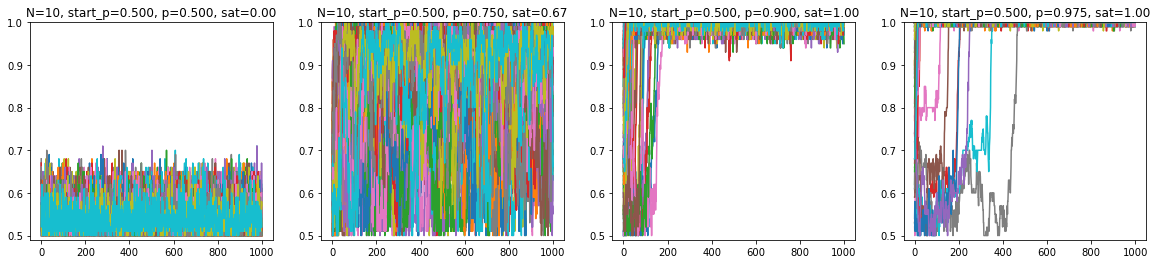

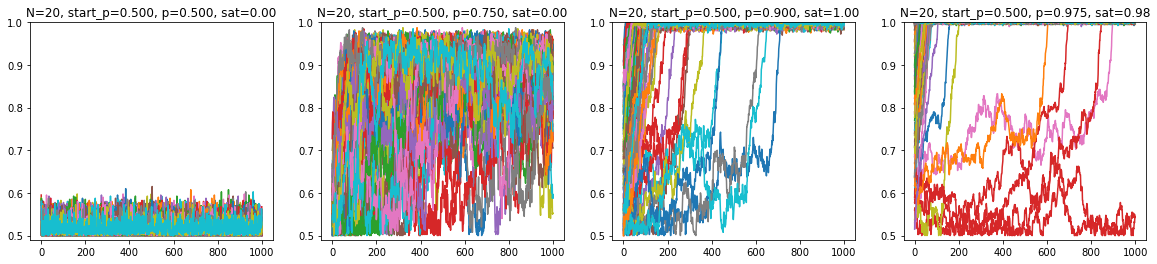

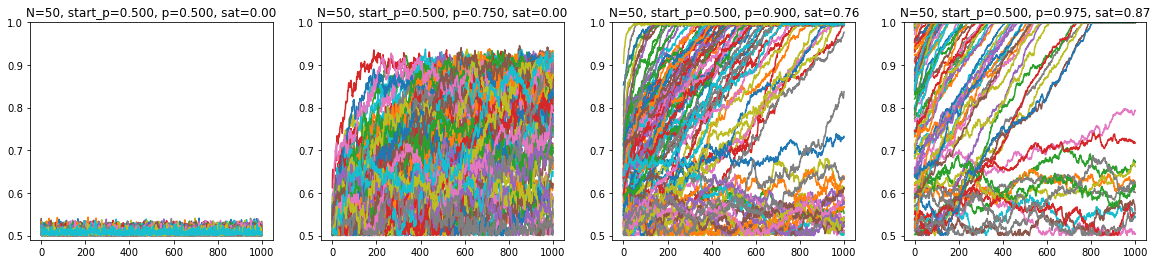

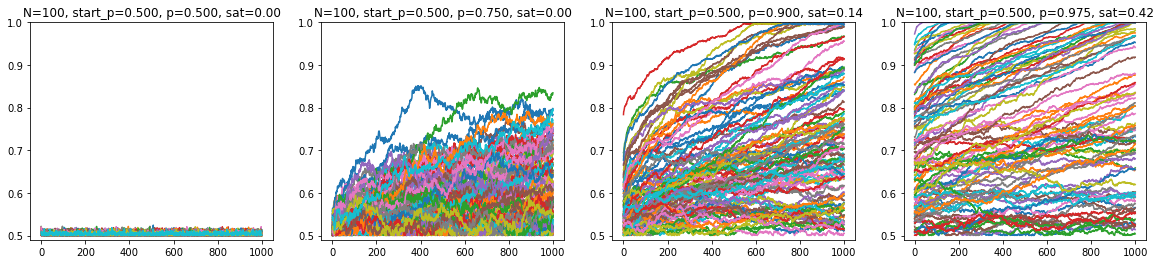

In [6]:
# fixed starting_p=0.5
p0, starting_p, num_frames, n_jobs, num_trajectories_per_job = 0.5, 0.5, 1000, 20, 5
ps = [0.50, 0.75, 0.90, 0.975]
Ns = [10, 20, 50, 100]
saturation_limits = [0.9, 0.95, 0.95, 0.95]
for N, saturation_limit in zip(Ns, saturation_limits):
    r = get_saturation(N, p0, [starting_p] * len(ps), ps, num_frames,
                         n_jobs, num_trajectories_per_job, saturation_limit)
    results.extend(r)

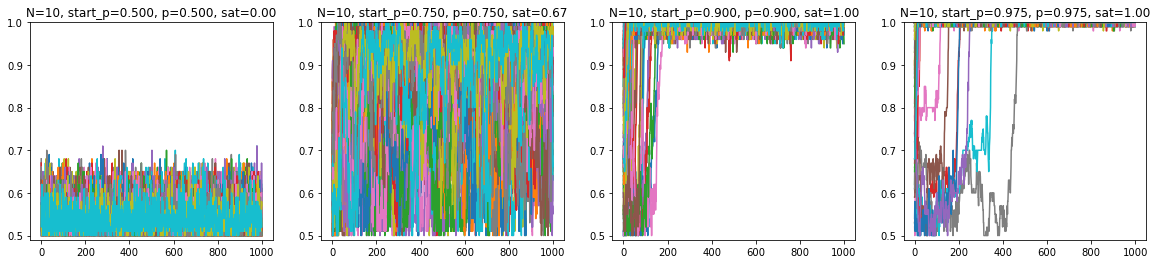

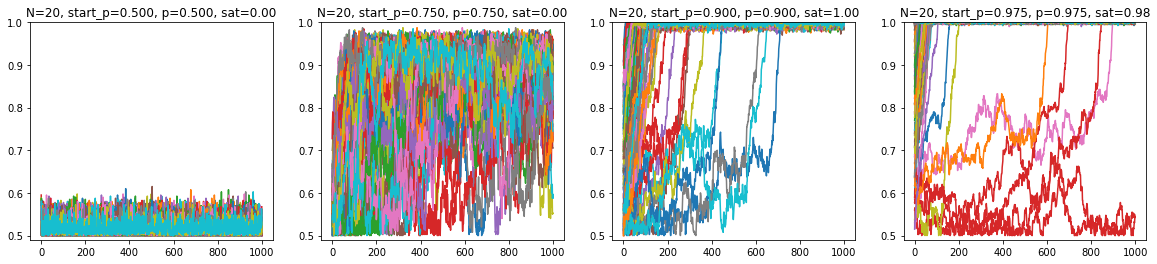

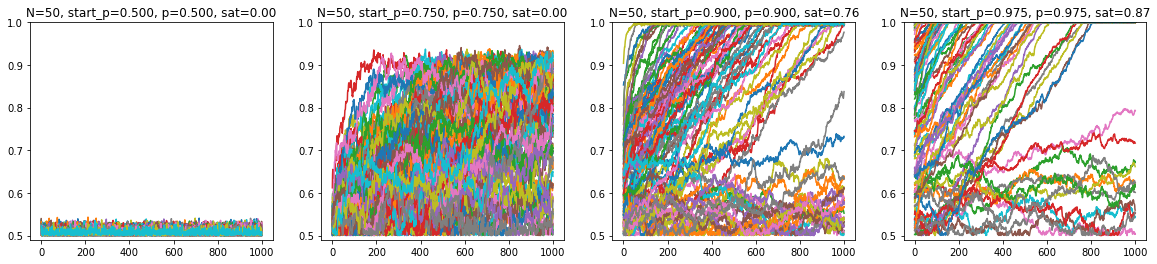

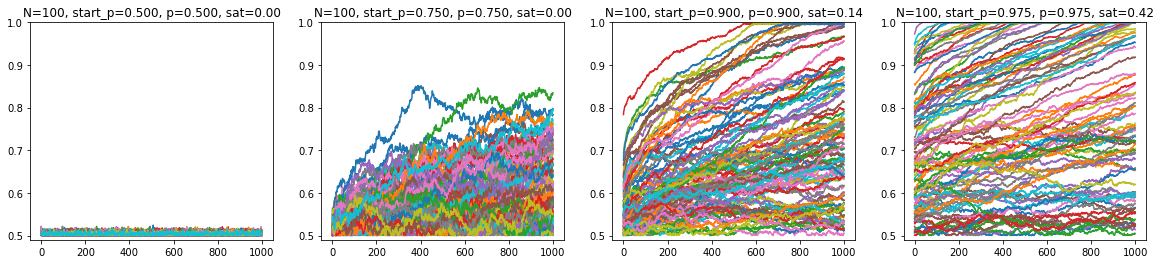

In [7]:
# starting_p=p
p0, num_frames, n_jobs, num_trajectories_per_job = 0.5, 1000, 20, 5
ps = starting_ps = [0.50, 0.75, 0.90, 0.975]
Ns = [10, 20, 50, 100]
saturation_limits = [0.9, 0.95, 0.95, 0.95]
for N, saturation_limit in zip(Ns, saturation_limits):
    r = get_saturation(N, p0, starting_ps, ps, num_frames,
                         n_jobs, num_trajectories_per_job, saturation_limit)
    results.extend(r)

In [8]:
# fixed starting_p=0.5
p0, starting_p, num_frames, n_jobs, num_trajectories_per_job = 0.5, 0.5, 1000, 20, 5
ps = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]
Ns =                [10,   20,   30,   40,   50,   60,   70,   80,   90,   100 ]
saturation_limits = [0.90, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
for N, saturation_limit in zip(Ns, saturation_limits):
    r = get_saturation(N, p0, [starting_p] * len(ps), ps, num_frames,
                         n_jobs, num_trajectories_per_job, saturation_limit,
                         draw_plots=False)
    results.extend(r)

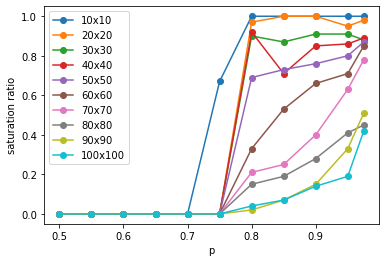

In [9]:
# (N, p0, starting_p, p, saturation, trajectories)
for N, saturation_limit in zip(Ns, saturation_limits):
    xs = [r[3] for r in results_selected if r[0] == N]
    ys = [np.mean([np.mean(t[-10:]) > saturation_limit for t in r[5]])
          for r in results[-(len(Ns)*len(ps)):] if r[0] == N]
    plt.plot(xs, ys, marker='o')
plt.xlabel('p')
plt.ylabel('saturation ratio')
plt.legend([f'{N}x{N}' for N in Ns])